## TIM NEP CALCULATION
JPF 15Oct2020

What it does:
 - Computes loading and noise as a function of frequency band
 - Complements other version that tracks variation in spill, resolution
 
Things that aren't great:
 - Need to specify how much of the power spill from the warm optics will eventually end up at the sky...
 - Noise model needs checking

In [1]:
# packages
import os
import numpy as _np
import scipy.constants as _con
from scipy.integrate import quad
from scipy.integrate import trapz
import pandas as _pd
import matplotlib.pyplot as _plt

# constants
k = _con.k  # Boltzmann constant (J/K)
c = _con.c  # Speed of light (m/s)
h = _con.h  # Planck's Constant (J-s)

In [2]:
# physics utility functions
def n_occ (T,v):
    """Photon mode occupation number of a black body of temperature T at frequency v"""
    return 1./(_np.exp(h*v/(k*T))-1)

def IBlackBody (T, v, pol=False):
    """Planck's Law spectral radiance - radiated power (in the normal direction) per steradian
    per square meter per Hertz at frequency v - for a blackbody at temperature T.
    If pol=True, returns for one polarization (half the power of the standard expression)."""
    polfactor = 1 if pol else 2
    return polfactor * h/(c**2)*(v**3)*n_occ(T,v)

def PBBSingleModed (T, v1=0, v2=_np.inf, pol=False):
    """Planck's Law radiative power received by an ideal single-moded
    receiver sensitive over frequency band [v1,v2] observing a blackbody at temperature T.
    If pol=True, returns for one polarization (half the power of the standard expression)."""
    (out,err) = quad(lambda v: IBlackBody(T,v,pol=pol)*(c/v)**2, v1, v2)
    return out

def NEP_photon (T,eta,v1=0,v2=_np.inf, pol=False, narrow=False):
    """Photon NEP [W/rtHz] for a noiseless detector observing temperature T
    with quantum efficiency eta over a frequency band [v1,v2].
    Defined with an integral to hander wider bands; faster with narrow=True."""
    polfactor = 1 if pol else 2 # sum incoherently over two polarization modes
    if narrow:
        v0 = (v1+v2)/2.
        dv = (v2-v1)
        return _np.sqrt(2*polfactor)*h*v0*_np.sqrt(dv*eta*n_occ(T,v0)*(1+eta*n_occ(T,v0)))
    else:
        integrand = lambda v: eta*(h*v)**2*n_occ(T,v) + (eta*h*v*n_occ(T,v))**2
        # integrate and incorporate the factor of 2 from NEP definition
        return _np.sqrt(2*polfactor*quad(integrand,v1,v2)[0])

In [3]:
class amModel:
# Encapsulates an am atmosphere model
# Columns: f (GHz), tx , Tb (K), I (watt*cm-2*GHz-1*sr-1)
# tx: transmittance
# Tb: Planck brightness temperature (redundant with I)
# I: Spectral radiance (unpolarized)
    def __init__(self, filename, label=None):
        '''Initialize a new am model (code assumes we know the units!!!)'''
        self.atmo = _pd.read_csv(filename,header = None, sep=' ', names=['vGHz','tx','Tb','I'])
        self.atmo['n'] = self.atmo['I']*1e-5*c**2/(2*h*(self.atmo['vGHz']*1e9)**3)
        self.label=label
    def I(self,v):
        '''Atmospheric intensity as a function of frequency (W/m2/Hz/sr, dual-pol)'''
        return _np.interp(v/1e9,self.atmo['vGHz'],self.atmo['I'])*1e-5 # intensity in W/m2/Hz/sr (dual-pol)
    def n(self,v):
        '''Mode occupation number '''
        return self.I(v)*c**2/(2*h*v**3) # mode occupation number as a function of frequency
    def P(self,v1,v2,pol=False):
        """Returns the unobstructed single-moded power from the atmosphere model in a given band"""
        # implemented numerically, assuming that the data file is sampled much more finely than we need
        polfactor = 2 if pol else 1 # Iatm is unpolarized, so we divide by 2 for single-pol
        temp = self.atmo[(self.atmo['vGHz']>=v1/1e9) & (self.atmo['vGHz']<v2/1e9)]
        return trapz(temp['I']*1e-5 * (c/(temp['vGHz']*1e9))**2,x=temp['vGHz']*1e9)/polfactor
    def NEP(self,eta,v1,v2,pol=False):
        """Atmospheric NEP associated with a given band observed with efficiency eta"""
        # implemented numerically, assuming that the data file is sampled much more finely than we need
        polfactor = 1 if pol else 2 # sum incoherently over two polarization modes
        temp = self.atmo[(self.atmo['vGHz']>=v1/1e9) & (self.atmo['vGHz']<v2/1e9)]
        return _np.sqrt( polfactor * trapz( 
            (h*temp['vGHz']*1e9)**2*eta*temp['n'] + (eta*h*temp['vGHz']*1e9*temp['n'])**2,
            x=temp['vGHz']*1e9))

In [4]:
# define the warm and cold optics
# Warm primary mirror, visible only through grating
Tprimary = 250. # Kelvin
epsPrimary = 0.005 # Emissivity of the primary
# Window
Twin = 250. # Kelvin
epsWin = 0.005 # Emissivity
# Filters
Tvcs2 = 175. # Kelvin
epsVCS2 = 0.005
Tvcs1 = 65. # Kelvin
epsVCS1 = 0.005
# Blaze factor for the grating: assume 1-fBlaze gets lost to the box
fBlaze = 0.7
# Cold optics box, assumed visible across full band
Toptics = 4.8 # Kelvin
#Toptics = 3.4 # Kelvin
#Toptics = 6 # Kelvin
epsOptics = 0.005 # Emissivity of the cold reflectors

# How much can we spill to the sky from the warm stages?
# Setting these to 0 terminates all spilled power warm, 1 assumes all goes to the cold sky
fSkySecondary = 0.98
fSkyPrimary = 0.7
fSkyObscuration = 0.7
fSkySpider = 0.7

# Detector
detEff = 0.95 # efficiency of the detector itself
pol=False # polarization-insensitive

# Wide bandwidth of detector
#Actual band, but that's too narrow. Widen by 20%
#SWlambda = _np.array([240e-6,317e-6]) # meters
#LWlambda = _np.array([317e-6,420e-6]) # meters
SWlambda = _np.array([240e-6*0.8,317e-6*1.2]) # meters
LWlambda = _np.array([317e-6*0.8,420e-6*1.2]) # meters
SWnu = c/SWlambda[::-1] # Hz
LWnu = c/LWlambda[::-1] # Hz

# Atmosphere
atmo = amModel('Antarctic_DJF_37km_0_2000_10M_45_1.out',label='37km')

In [5]:
# create pandas data frame of spill / transmission
# first, geometric spill only (eyeballed from Isaac's plots for wide, narrow from LW (73,64))
# added some emissivity to each reflecting surface
# zeroed out everything out of band past the slit
spill = _pd.DataFrame({'Stage':['camera','grating','collimator','coll fold','slit mirror','slit','offner out','offner m3','offner m2','offner m1','offner in','vcs1','vcs2','window','secondary','primary','obscuration','spider'],
                      'Tspill':[Toptics,Toptics,Toptics,Toptics,Toptics,Toptics,Toptics,Toptics,Toptics,Toptics,Toptics,Tvcs1,Tvcs2,Twin,Tprimary,Tprimary,Tprimary,Tprimary],
                       'SpillWide':[0.18,0.06,0.17,0.34,0.17,0.08,0,0,0,0,0,0,0,0,0,0,0,0],
                     'SpillNarrow':[epsOptics  ,0.1032 + (1-fBlaze), epsOptics ,epsOptics   ,epsOptics   ,0.1615*fBlaze,epsOptics ,epsOptics   ,0.1734*fBlaze,epsOptics ,  epsOptics ,epsVCS1,epsVCS2,epsWin,fBlaze*0.0513*(1-fSkySecondary)+epsPrimary,fBlaze*0.025*(1-fSkyPrimary)+epsPrimary,fBlaze*0.0013*(1-fSkyObscuration),fBlaze*0.0077*(1-fSkySpider)]})
effSky = 1-spill.SpillNarrow.sum()

In [6]:
# define the spectrometer bands in wavelength and frequency space
# SWcam
npix_spectral_SW = 63*2 # hex-packed 64x63, so 126 distinct bands
lambda_min = 240e-6 # meters
lambda_max = 317e-6 # meters
RfactorLW = 2.2 # This is the ratio of ideal R (non-overlapping bands) / actual R, a number >1 for overlap 
RfactorSW = 2.2 # This is the ratio of ideal R (non-overlapping bands) / actual R, a number >1 for overlap 

vMin = c/lambda_max
vMax = c/lambda_min
wvl_edge = _np.logspace(_np.log10(lambda_min),_np.log10(lambda_max),
                  num=npix_spectral_SW+1)
nu_edgeSW = c/wvl_edge
wvlSW = (wvl_edge[1:] + wvl_edge[:-1])/2.
bandsSW = _pd.DataFrame(data=wvlSW,columns=['lamb'])
bandsSW['v']=c/bandsSW['lamb']
bandsSW['dv']=-_np.diff(nu_edgeSW)*RfactorSW

# LWcam
npix_spectral_LW = 63*2 # hex-packed 51x63, so 126 distinct bands
lambda_min = 317e-6 # meters
lambda_max = 420e-6 # meters
vMin = c/lambda_max
vMax = c/lambda_min
wvl_edge = _np.logspace(_np.log10(lambda_min),_np.log10(lambda_max),
                  num=npix_spectral_LW+1)
nu_edgeLW = c/wvl_edge
wvlLW = (wvl_edge[1:] + wvl_edge[:-1])/2.
bandsLW = _pd.DataFrame(data=wvlLW,columns=['lamb'])
bandsLW['v']=c/bandsLW['lamb']
bandsLW['dv']=-_np.diff(nu_edgeLW)*RfactorLW

In [7]:
# optical loading model
# compute the wide-band loading separately
spill['PWideLW'] = spill.apply(lambda row: PBBSingleModed(row.Tspill,v1=_np.min(LWnu),v2=_np.max(LWnu),pol=pol)*row.SpillWide, axis=1)
spill['PWideSW'] = spill.apply(lambda row: PBBSingleModed(row.Tspill,v1=_np.min(SWnu),v2=_np.max(SWnu),pol=pol)*row.SpillWide, axis=1)

# in-band power from each element
for idx,row in spill.iterrows():
    for bands in [bandsSW,bandsLW]:
        bands['P'+row.Stage] = row.SpillNarrow*IBlackBody(row.Tspill,bands['v'],pol=pol)*bands['dv']*bands['lamb']**2

# wide-band power from each element
for idx,row in spill.iterrows():
    bandsSW['PW'+row.Stage] = row.PWideSW
    bandsLW['PW'+row.Stage] = row.PWideLW

#atmosphere and sum
for bands in (bandsSW,bandsLW):
    # Atmosphere
    bands['Patm'] = effSky*bands.apply(lambda row: atmo.P(v1=row.v-row.dv/2,v2=row.v+row.dv/2,pol=pol),axis=1)
    # Put it all together
    bands['P'] = bands.filter(regex='P.+').sum(axis=1)
    # Sub-sums
    bands['PPfpu2grating']=bands.filter(items=['Pcamera','Pgrating','PWcamera','PWgrating']).sum(axis=1)
    bands['PPgrating2slit']=bands.filter(items=['Pcollimator','Pcoll fold','Pslit mirror','Pslit','PWcollimator','PWcoll fold','PWslit mirror','PWslit']).sum(axis=1)
    bands['PPoffner'] = bands.filter(regex='Poffner.*').sum(axis=1)
    bands['PPcold'] = bands.filter(items=['PPfpu2grating','PPgrating2slit','PPoffner']).sum(axis=1)
    bands['PPfilters'] = bands.filter(items=['Pvcs1','Pvcs2','Pwin']).sum(axis=1)
    bands['PPwarm'] = bands.filter(items=['Psecondary','Pprimary','Pobscuration','Pspider']).sum(axis=1)
    # some equivalent emissivities
    bands['epsWarm'] = bands.apply(lambda row: row.PPwarm/PBBSingleModed(Tprimary, v1=row.v-row.dv/2,
                                                             v2=row.v+row.dv/2, pol=pol), axis=1)
    bands['epsCold'] = bands.apply(lambda row: row.PPcold/PBBSingleModed(Toptics, _np.min(bands.v),
                                                             _np.max(bands.v), pol=pol), axis=1)

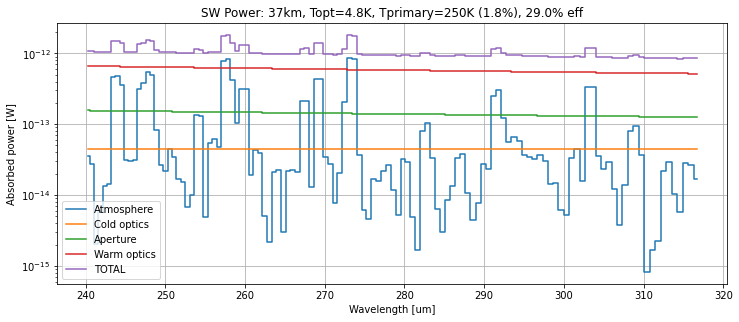

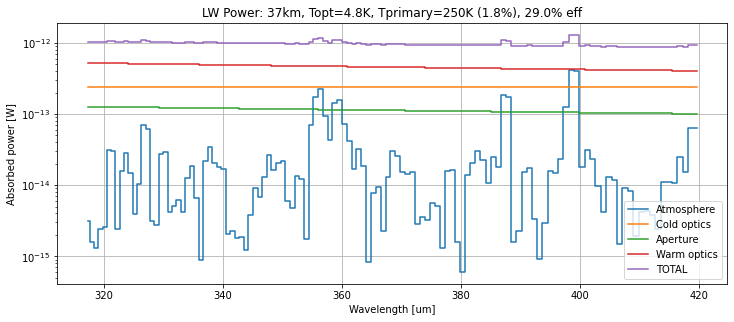

In [8]:
# plot the optical loads
for bandstr,bands in zip(['SW','LW'],[bandsSW,bandsLW]):
    _plt.figure(figsize=(12,4.8))
    ax=_plt.step(bands['lamb']*1e6,bands['Patm'],where='mid',label='Atmosphere')
    _plt.step(bands['lamb']*1e6,bands['PPcold'],where='mid',label='Cold optics')
    _plt.step(bands['lamb']*1e6,bands['PPfilters'],where='mid',label='Aperture')
    _plt.step(bands['lamb']*1e6,bands['PPwarm'],where='mid',label='Warm optics')
    _plt.step(bands['lamb']*1e6,bands['P'],where='mid',label='TOTAL')
    _plt.gca().set_yscale("log")
    _plt.grid()
    _plt.xlabel('Wavelength [um]')
    _plt.ylabel('Absorbed power [W]')
    _plt.title('%s Power: %s, Topt=%.1fK, Tprimary=%dK (%.1f%%), %.1f%% eff'%(
        bandstr,atmo.label, Toptics, Tprimary,_np.mean(bands.epsWarm)*100,effSky*100))
    _plt.legend()

In [9]:
# noise model NOT SURE IF THIS IS WORKING RIGHT NOW
for bandstr,bands,wide in zip(['SW','LW'],[bandsSW,bandsLW],[SWnu,LWnu]):
    bands['NEPatm'] = bands.apply(lambda row: atmo.NEP(v1=row.v-row.dv/2,v2=row.v+row.dv/2,eta=effSky,pol=pol),axis=1)
    bands['NEPwarm'] = bands.apply(lambda row: NEP_photon(Tprimary,row.epsWarm,v1=row.v-row.dv/2,
                                                             v2=row.v+row.dv/2, pol=pol, narrow=True),axis=1)
    bands['NEPcold'] = bands.apply(lambda row: NEP_photon(Toptics,row.epsWarm, wide[0],
                                                             wide[1], pol=pol, narrow=True),axis=1)
    idx = spill[spill.Stage=='vcs1'].index.values
    bands['NEPvcs1'] = bands.apply(lambda row: NEP_photon(spill.Tspill[idx],spill.SpillNarrow[idx], v1=row.v-row.dv/2,
                                                             v2=row.v+row.dv/2, pol=pol, narrow=True),axis=1)
    idx = spill[spill.Stage=='vcs2'].index.values
    bands['NEPvcs2'] = bands.apply(lambda row: NEP_photon(spill.Tspill[idx],spill.SpillNarrow[idx], v1=row.v-row.dv/2,
                                                             v2=row.v+row.dv/2, pol=pol, narrow=True),axis=1)
    idx = spill[spill.Stage=='window'].index.values
    bands['NEPwin'] = bands.apply(lambda row: NEP_photon(spill.Tspill[idx],spill.SpillNarrow[idx], v1=row.v-row.dv/2,
                                                             v2=row.v+row.dv/2, pol=pol, narrow=True),axis=1)
    bands['NEP'] = _np.sqrt(bands['NEPwarm']**2 + bands['NEPcold']**2 + bands['NEPatm']**2 + bands['NEPvcs1']**2 
                            + bands['NEPvcs2']**2 + bands['NEPwin']**2)

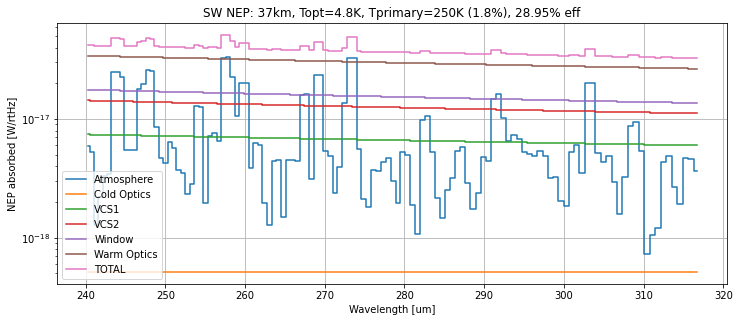

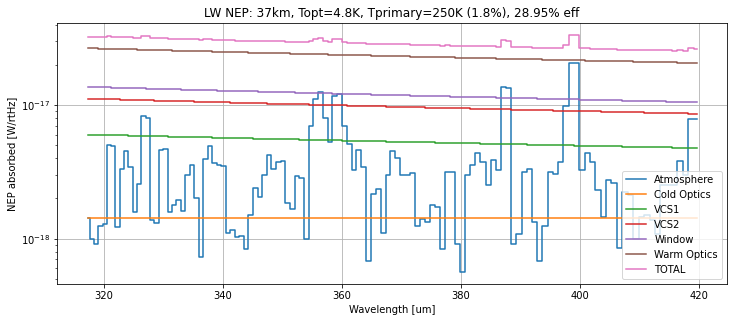

In [10]:
# plot the optical NEPs
for bandstr,bands in zip(['SW','LW'],[bandsSW,bandsLW]):
    _plt.figure(figsize=(12,4.8))
    _plt.step(bands['lamb']*1e6,bands['NEPatm'],where='mid',label='Atmosphere')
    _plt.step(bands['lamb']*1e6,bands['NEPcold'],where='mid',label='Cold Optics')
    _plt.step(bands['lamb']*1e6,bands['NEPvcs1'],where='mid',label='VCS1')
    _plt.step(bands['lamb']*1e6,bands['NEPvcs2'],where='mid',label='VCS2')
    _plt.step(bands['lamb']*1e6,bands['NEPwin'],where='mid',label='Window')
    _plt.step(bands['lamb']*1e6,bands['NEPwarm'],where='mid',label='Warm Optics')
    _plt.step(bands['lamb']*1e6,bands['NEP'],where='mid',label='TOTAL')
    _plt.gca().set_yscale("log")
    _plt.grid()
    _plt.xlabel('Wavelength [um]')
    _plt.ylabel('NEP absorbed [W/rtHz]')
    _plt.title('%s NEP: %s, Topt=%.1fK, Tprimary=%dK (%.1f%%), %.2f%% eff'%(
        bandstr, atmo.label, Toptics,Tprimary,_np.mean(bands.epsWarm)*100,effSky*100))
    _plt.legend()